In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import time

from pycsou.linop.conv import Convolve2D
from pycsou.func.loss import SquaredL2Loss
from pycsou.func.penalty import SquaredL2Norm, L2Norm, L1Norm, NonNegativeOrthant
from pycsou.opt.proxalgs import APGD, PDS
from pycsou.linop.diff import Gradient

from scripts.functionals import DCT2, HuberNorm, OptiConvolve2D
pass

### Comparing Old and new Convolve2D Method in precision

[17 32]
(slice(4, 13, None), slice(7, 23, None), slice(0, 3, None))
(slice(4, 13, None), slice(8, 24, None), slice(0, 3, None))
Custom2D vs Convolve2D conv norm difference:  9.597259988851263e-14
Custom2D vs Convolve2D conv mean difference:  3.3430048852601935e-15
Custom2D vs Convolve2D corr norm difference:  8.532524417946144e-14
Custom2D vs Convolve2D corr mean difference:  3.044889443462698e-15


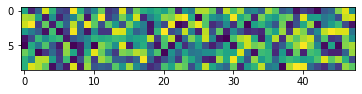

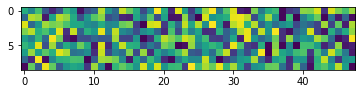

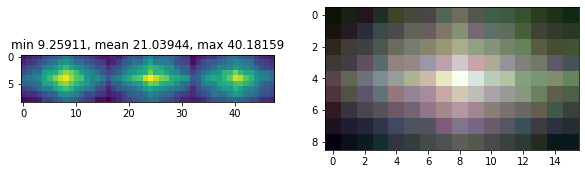

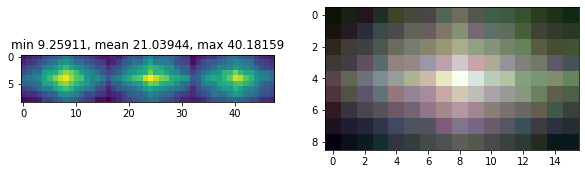

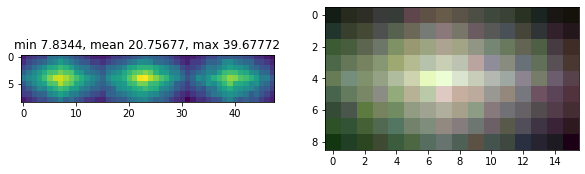

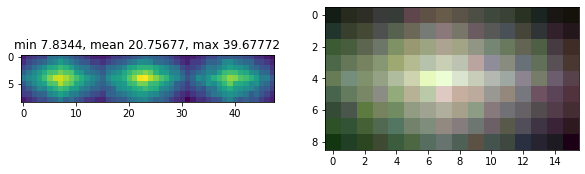

In [2]:
# ===========================================================================
# Custom Parameters: 
# - shape can be any size and channel number can be 1, 3, 4
# - dtype can be np.float32 or np.float64 if you want to see the impact on 
#   the precision with the original technique
    
shape = (9, 16, 3)
# shape = (1000, 1000, 3)
dtype = np.float64
offset_padding_factor = None

# =====================================================================

shape2d = shape[0:2]
y = np.random.rand(*shape).astype(dtype)
x = np.random.rand(*shape).astype(dtype)
psf = np.random.rand(*shape).astype(dtype)

def conc_channels(v):
    return np.concatenate([v[:,:,i] for i in range(v.shape[2])], axis=1)

plt.figure()
plt.imshow(conc_channels(x))
plt.figure()
plt.imshow(conc_channels(psf))

H = OptiConvolve2D(psf)
print(H.fshape2d)
print(H.fslice2d_conv)
print(H.fslice2d_corr)
Hops = [Convolve2D(size=y.size/shape[2], filter=psf[:,:,i], shape=shape2d, method='fft') for i in range(shape[2])]

conv2d_conv = np.zeros_like(y)
for i in range(shape[2]):
    conv2d_conv[:,:,i] = Hops[i](x[:,:,i].flatten()).reshape(*shape2d)
custom2d_conv = H(x.flatten()).reshape(*shape)

conv2d_corr = np.zeros_like(y)
for i in range(shape[2]):
    conv2d_corr[:,:,i] = Hops[i].adjoint(y[:,:,i].flatten()).reshape(*shape2d)
custom2d_corr = H.adjoint(y.flatten()).reshape(*shape)

print("Custom2D vs Convolve2D conv norm difference: ", np.linalg.norm(conv2d_conv - custom2d_conv))
print("Custom2D vs Convolve2D conv mean difference: ", np.mean(np.abs(conv2d_conv - custom2d_conv)))
print("Custom2D vs Convolve2D corr norm difference: ", np.linalg.norm(conv2d_corr - custom2d_corr))
print("Custom2D vs Convolve2D corr mean difference: ", np.mean(np.abs(conv2d_corr - custom2d_corr)))

for t in [conv2d_conv, custom2d_conv, conv2d_corr, custom2d_corr]:
    fig, axs = plt.subplots(1,2, figsize=(10,10))
    axs[0].imshow(conc_channels(t))
    axs[0].set_title(f"min {round(t.min(),5)}, mean {round(t.mean(),5)}, max {round(t.max(), 5)}")
    t = (t - t.min())/(t.max() - t.min())
    axs[1].imshow(t)


### Comparing old and new Convolve2D method for Inverse Problem

In [3]:
shape = (1000, 1000, 3)
dtype = np.float32

shape2d = shape[0:2]
y = np.random.rand(*shape).astype(dtype)
psf = np.random.rand(*shape).astype(dtype)

def custom2d(y, psf, niter=30):
    Hop = OptiConvolve2D(psf)
    Hop.compute_lipschitz_cst(tol=5e-1)
    # Hop.compute_lipschitz_cst()
    lambda_ = 0.1
    l22_loss = (1 / 2) * SquaredL2Loss(dim=Hop.shape[0], data=y.flatten())
    F = l22_loss * Hop + lambda_ * SquaredL2Norm(dim=Hop.shape[0])

    apgd = APGD(dim=Hop.shape[1], F=F, acceleration='CD', verbose=None,
                min_iter=1, max_iter=niter)

    estimate, _, _ = apgd.iterate()
    estimate = estimate['iterand'].reshape(y.shape)
    return estimate, Hop(estimate.flatten()).reshape(y.shape)
    
def conv2d(y, psf, niter=30):
    complete_estimate = np.zeros_like(y)
    complete_foresti = np.zeros_like(y)
    if len(y.shape) < 3:
        Hop = Convolve2D(size=y.size, filter=psf, shape=y.shape, method='fft')
        Hop.compute_lipschitz_cst(tol=5e-1)
        lambda_ = 0.1
        l22_loss = (1 / 2) * SquaredL2Loss(dim=Hop.shape[0], data=y.flatten())
        F = l22_loss * Hop + lambda_ * SquaredL2Norm(dim=Hop.shape[0])

        apgd = APGD(dim=Hop.shape[1], F=F, acceleration='CD', verbose=None,
                    min_iter=1, max_iter=niter)

        estimate, _, _ = apgd.iterate()
        estimate = estimate['iterand'].reshape(y.shape)
        complete_estimate = estimate
        complete_foresti = Hop(estimate.flatten()).reshape(y.shape)
    else:
        for i in range(y.shape[2]):
            yi_shape = y[:,:,i].shape
            Hop = Convolve2D(size=y[:,:,i].size, filter=psf[:,:,i], shape=yi_shape, method='fft')
            Hop.compute_lipschitz_cst(tol=5e-1)
            lambda_ = 0.1
            l22_loss = (1 / 2) * SquaredL2Loss(dim=Hop.shape[0], data=y[:,:,i].flatten())
            F = l22_loss * Hop + lambda_ * SquaredL2Norm(dim=Hop.shape[0])

            apgd = APGD(dim=Hop.shape[1], F=F, acceleration='CD', verbose=None,
                        min_iter=1, max_iter=niter)

            estimate, _, _ = apgd.iterate()
            estimate = estimate['iterand'].reshape(yi_shape)
            complete_estimate[:,:,i] = estimate
            complete_foresti[:,:,i] = Hop(estimate.flatten()).reshape(yi_shape)
    return complete_estimate, complete_foresti

iterations = 15

start_time = time.process_time()    
for _ in range(iterations):
    custom2d_esti, custom2d_foresti = custom2d(y, psf)
custom2d_elapsed = (time.process_time() - start_time)/iterations
print("Custom2D time:", custom2d_elapsed)

start_time = time.process_time()    
for _ in range(iterations):
    conv2d_esti, conv2d_foresti = conv2d(y, psf)
conv2d_elapsed = (time.process_time() - start_time)/iterations
print("Convolve2D time:", conv2d_elapsed)

_, axs = plt.subplots(2, 4, figsize=(20, 10))
axs[0][0].imshow(y, vmin=0, vmax=1)
axs[0][0].set_title("Measurement")
axs[1][0].imshow(psf, vmin=0, vmax=1)
axs[1][0].set_title("PSF")
axs[0][1].imshow(conv2d_esti, vmin=0, vmax=1)
axs[0][1].set_title("Convolve2D Estimate")
axs[1][1].imshow(custom2d_esti, vmin=0, vmax=1)
axs[1][1].set_title("Custom2D Estimate")
axs[0][2].imshow(conv2d_foresti, vmin=0, vmax=1)
axs[0][2].set_title("Convolve2D Forward Estimate")
axs[1][2].imshow(custom2d_foresti, vmin=0, vmax=1)
axs[1][2].set_title("Custom2D Forward Estimate")
axs[0][3].imshow(conv2d_foresti - y, vmin=-1, vmax=1)
axs[0][3].set_title("Convolve2D difference between measurement and Forward")
axs[1][3].imshow(custom2d_foresti - y, vmin=-1, vmax=1)
axs[1][3].set_title("Custom2D difference between measurement and Forward")


/Users/alecflowers/Documents/EPFL/2021_fall/signal_processing/DiffuserCam/diffcam_env/lib/python3.8/site-packages/pycsou/core/functional.py:152: UserWarning: For differentiable and/or linear maps, consider the dedicated classes DifferentiableMap and LinearOperator.
  warnings.warn(


Custom2D time: 71.70664793333334


KeyboardInterrupt: 

In [ ]:
def bench(shape, dtype, iterations=100):
    shape2d = shape[0:2]
    y = np.random.rand(*shape).astype(dtype)
    x = np.random.rand(*shape).astype(dtype)
    psf = np.random.rand(*shape).astype(dtype)

    custom_H = OptiConvolve2D(psf)
    conv_H = [Convolve2D(size=psf.size/shape[2], filter=psf[:,:,i], shape=shape2d, method='fft') for i in range(shape[2])]

    start_time = time.process_time()    
    for _ in range(iterations):
        for i in range(shape[2]):
            conv_H[i](x[:,:,i].flatten())
    conv_average_elapsed_time_conv = (time.process_time() - start_time)/iterations
    print("Convolve2D conv:", conv_average_elapsed_time_conv)

    start_time = time.process_time()    
    for _ in range(iterations):
        custom_H(x.flatten())
    custom_average_elapsed_time_conv = (time.process_time() - start_time)/iterations
    print("Custom2D conv:", custom_average_elapsed_time_conv)

    start_time = time.process_time()
    for _ in range(iterations):
        for i in range(shape[2]):
            conv_H[i].adjoint(y[:,:,i].flatten())
    conv_average_elapsed_time_corr = (time.process_time() - start_time)/iterations
    print("Convolve2D corr:", conv_average_elapsed_time_corr)

    start_time = time.process_time()
    for _ in range(iterations):
        custom_H.adjoint(y.flatten())
    custom_average_elapsed_time_corr = (time.process_time() - start_time)/iterations
    print("Custom2D corr:", custom_average_elapsed_time_corr)
    
    return conv_average_elapsed_time_conv/custom_average_elapsed_time_conv,\
            conv_average_elapsed_time_corr/custom_average_elapsed_time_corr

dtype = np.float64
iterations = 100

spconv1, spcorr1 = bench((1000, 1000, 1), dtype, iterations)
spconv3, spcorr3 = bench((1000, 1000, 3), dtype, iterations)
print("gray Custom2D conv speedup:", spconv1)
print("gray Custom2D corr speedup:", spcorr1)
print("color Custom2D conv speedup:", spconv3)
print("color Custom2D corr speedup:", spcorr3)

